In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import leastsq
from scipy.special import jvp, yvp
from matplotlib import pyplot as plt
import sympy as sy

In [2]:
def Zmodel(f, R, L, C, Lcoupling):
    """ impedance of a series RLC circuit
    """
    w = 2*np.pi*f
    return ((R + 1j*(w*L - 1/(w*C)))**(-1) + (1j*w*Lcoupling)**(-1))**(-1)

def residuals(params, wf, Z):
    R, L, C, Lcoupling = params
    diff = Zmodel(f, R, L, C, Lcoupling) - Z
    return diff.real**2 + diff.imag**2

In [54]:
R = [3.35]#np.linspace(2.35, 3.35, 11)
data = [np.loadtxt("TL_Model_Perforated_Plate/fss_%.2f_9.txt" %r, delimiter=",") for r in R]
adata = [np.loadtxt("TL_Model_Perforated_Plate/absorber_%.2f_9.txt" %r, delimiter=",") for r in R]
D = 74.72e-3 # distance from the port to the FR4 layer
D = 30.92e-3
lz = 0.4e-3
f = data[0][:,0]
phase = np.exp(4j*np.pi*D*f/3e8)
epsFR4 = 4.4*(1-0.02j)
epsFR4 = 4.4 - 1j*0.049/(2*np.pi*f*8.85e-12)
Zslab = 1j*377/np.sqrt(epsFR4)*np.tan(2*np.pi*f/3e8*np.sqrt(epsFR4)*lz)
Zabs = adata[0][:,5] + 1j*adata[0][:,6]
Zfss = data[0][:,5]+1j*data[0][:,6]

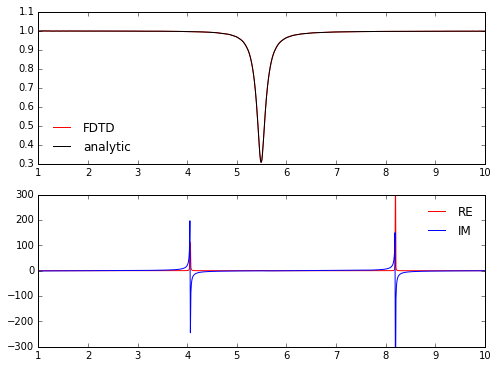

In [30]:
fig = plt.figure(figsize=(8,6))
ax1, ax2 = fig.add_subplot(211), fig.add_subplot(212)
S11 = (adata[0][:,1]+1j*adata[0][:,2])*phase
Zfss = (1/Zabs - 1/Zslab)**(-1)
Zmeta = Zfss*Zslab/(Zfss+Zslab)
ax1.plot(f/1e9, np.abs(S11), "r-", label="FDTD")
ax1.plot(f/1e9, np.abs((Zmeta-377)/(Zmeta+377)), "k-", label="analytic")
ax1.legend(loc="best").draw_frame(False)
ax2.plot(f/1e9, np.real((1-S11)/(1+S11)), "r-", label="RE")
ax2.plot(f/1e9, np.imag((1-S11)/(1+S11)), "b-", label="IM")

ax2.set_ylim([-300,300])
ax2.legend(loc="best").draw_frame(False)
plt.show()

In [31]:

ydata = leastsq(residuals, x0 = [0.5, 0.49e-9, 1e-12, 1e-9], args=(f, Zfss))

/home/stefan/.local/lib/python3.5/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


In [32]:
ydata

(array([ 1.01176277e+02,  3.90941792e-09,  5.39926784e-12, -4.43225581e-09]),
 5)

In [33]:
Rr, Ll, Cc, Lcoupling = ydata[0]
#Rr, Ll, Cc = 0.65, 0.49e-9, 1e-12
plt.plot(f/1e9, Zfss.imag, "r-", label="$\mathrm{Im}(Z_{fss})$")
plt.plot(f/1e9, Zfss.real, "b-", label="$\mathrm{Re}(Z_{fss})$")
plt.plot(f/1e9, Zslab.imag, "m-", label="$\mathrm{Im}(Z_{d})$")
plt.plot(f/1e9, Zslab.real, "c-", label="$\mathrm{Re}(Z_{d})$")
plt.plot(f/1e9, Zcoup.imag, "m--", label="$\mathrm{Im}(Z_{coup})$")
plt.plot(f/1e9, Zcoup.real, "c--", label="$\mathrm{Re}(Z_{coup})$")
plt.xlim([2,8])
#plt.ylim([-80,10])
plt.show()

AttributeError: 'list' object has no attribute 'imag'

In [46]:
R = np.array([2.65, 2.75, 2.85])
absorber = [np.loadtxt("TL_Model_Perforated_Plate/absorber_%.2f_9.6.txt" %r, delimiter=",") for r in R]
fss = [np.loadtxt("TL_Model_Perforated_Plate/fss_%.2f_9.6.txt" %r, delimiter=",") for r in R]
w = 2*np.pi*fss[0][:, 0]
Zabs = [dat[:,5] + 1j*dat[:,6] for dat in absorber]
Zfss = [dat[:,5] + 1j*dat[:,6] for dat in fss]
epsFR4 = 4.4 +1j*0.049/(w*8.85e-12)
Zslab = 1j*377/np.sqrt(epsFR4)*np.tan(w/3e8*np.sqrt(epsFR4)*lz)
Zcoup = [1/(1/Zabs[i] - 1/Zfss[i]) - Zslab for i in range(len(absorber))]
Znew = lambda zf, zc: 1/(1/zf + 1/(Zslab+zc))
Zmeta = [Znew(zf, zc) for zf, zc in zip(Zfss, Zcoup)]

In [47]:
for i in range(len(absorber)):
    print("Zabs.shape, Zfss.shape", R[i], Zabs[i].shape, Zfss[i].shape, Zmeta[i].shape)

Zabs.shape, Zfss.shape 2.65 (1900,) (1900,) (1900,)
Zabs.shape, Zfss.shape 2.75 (1900,) (1900,) (1900,)
Zabs.shape, Zfss.shape 2.85 (1900,) (1900,) (1900,)


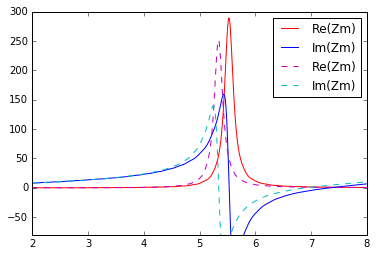

In [55]:
idx = 0
plt.plot(w/(2e9*np.pi), Zmeta[idx].real, "r-", label="Re(Zm)")
plt.plot(w/(2e9*np.pi), Zmeta[idx].imag, "b-", label="Im(Zm)")
idx = -1
plt.plot(w/(2e9*np.pi), Zmeta[idx].real, "m--", label="Re(Zm)")
plt.plot(w/(2e9*np.pi), Zmeta[idx].imag, "c--", label="Im(Zm)")
plt.xlim([2,8])
plt.ylim([-80,300])
plt.legend()
plt.show()

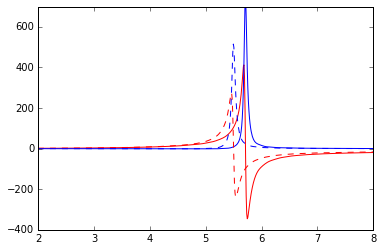

In [56]:
idx = 0
plt.plot(w/(2e9*np.pi), Zcoup[idx].imag, "r-", label="Im(Zc1)")
plt.plot(w/(2e9*np.pi), Zcoup[idx].real, "b-", label="Re(Zc1)")
idx= -1
plt.plot(w/(2e9*np.pi), Zcoup[idx].imag, "r--", label="Im(Zc2)")
plt.plot(w/(2e9*np.pi), Zcoup[idx].real, "b--", label="Re(Zc2)")
plt.xlim([2,8])
plt.ylim([-400,700])
plt.show()

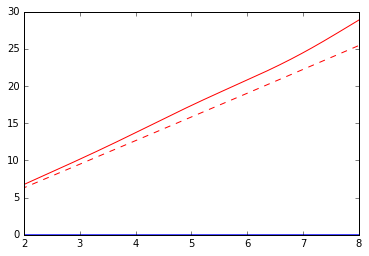

In [71]:
dslab = np.loadtxt("TL_Model_Perforated_Plate/slab_3.35.txt", delimiter=",")
Zs = dslab[:,5] + 1j*dslab[:,6]
plt.plot(dslab[:,0]/1e9, Zs.imag, "r-")
plt.plot(dslab[:,0]/1e9, Zs.real, "b-")
plt.plot(f/1e9, Zslab.imag, "r--")
plt.plot(f/1e9, Zslab.real, "b--")
plt.xlim([2,8])
plt.ylim([0,30])
plt.show()